<a href="https://colab.research.google.com/github/lsescares/memoria/blob/main/leer_xml_memoria_final_inicio_del_trabajo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import os

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd"/content/gdrive/MyDrive/memoria/"
!ls
#el comando ls deberia mostrar la imagen grande y el jupyterNotebook

/content/gdrive/MyDrive/memoria
 comandos_terminal.txt	 ejemplo_x5_z0.tif
 ejemplo.ndpi		 ejemplo.xml
 ejemplo.ndpi.ndpa	'estado 28 5 2021.gdoc'
 ejemplo_split		 largetifftools-1.4
 ejemplo_x0.625_z0.tif	 pre-resumen.gdoc
 ejemplo_x1.25_z0.tif	'topicos de presentación avance 4 junio.gdoc'
 ejemplo_x2.5_z0.tif


In [ ]:
import xml.etree.ElementTree as ET

path_ndpi_file='ejemplo.xml'#un archiv ndpa es un tipo de archivo xml
lado_parche = 100
comandos_ndpi = main (path_ndpi_file, lado_parche)

#print('cantidad de parches a cortar = ',contador_parches(esquinas))

NameError: ignored

In [ ]:
def main(path_xml, lado_parche):
    anotaciones_ndpi = read_xml(path_xml)#leer xml y generar arbol
    print('anotaciones_ndpi:')
    [print(anotacion) for anotacion in anotaciones_ndpi]
    
    anotaciones_pixeles = transformacion_ndpi2pixeles(anotaciones_ndpi)#trasformacion coord ndpi to pixeles
    print('anotaciones_pixeles:')
    
    [print(anotacion) for anotacion in anotaciones_pixeles]
    
    contenedor_esquinas = get_esquinas_parches(lado_parche, anotaciones_pixeles)#generar las esquinas de los parches de la roi
    
    #[print( [print(esquina) for esquina in esquinas] ) for esquinas in contenedor_esquinas]#esto es una list comprehension anidada, deberia dar prints de estructura piramidal
    
    comandos_ndpisplit = get_comandos_terminal_ndpisplit(contenedor_esquinas, lado_parche)#generar los comandos para terminal para ndpi_split
    #[print(comando) for comando in comandos_ndpisplit]
    #print('cantidad de parches a cortar = ',contador_parches(esquinas[0]))
    return comandos_ndpisplit


################################################################################
import xml.etree.ElementTree as ET

path_ndpi_file='ejemplo.xml'#un archivo ndpa es un tipo de archivo xml
lado_parche = 100
comandos_ndpi = main (path_ndpi_file, lado_parche)
save_comandos_txt(comandos_ndpi)

#print(type(comandos_ndpi[0]))
#print('cantidad de parches a cortar = ',contador_parches(esquinas))    

anotaciones_ndpi:
[17378486, -8860522, 116507]
[16975832, -9043960, 156393]
[25895720, -3402991, 228013]
[28703368, -5780257, 93035]
[27894428, -7580282, 105140]
[26922018, -8182728, 163239]
[26064970, -2042065, 236743]
[15547612, 2758020, 398567]
[15374672, 6712600, 229496]
[19966664, 6854214, 165545]
[19683106, -4875903, 299866]
[18831042, -5884242, 167834]
[17253944, -7259061, 79502]
[18394424, -6909625, 317598]
[19175646, -8534359, 226460]
[0, 0, 100]
anotaciones_pixeles:
[120656, 12671, 513]
[118882, 11862, 688]
[158177, 36713, 1004]
[170545, 26240, 409]
[166982, 18310, 463]
[162698, 15656, 719]
[158922, 42708, 1042]
[112590, 63854, 1755]
[111828, 81275, 1010]
[132058, 81898, 729]
[130808, 30224, 1320]
[127055, 25782, 739]
[120107, 19725, 350]
[125131, 21265, 1399]
[128573, 14107, 997]
[44099, 51704, 0]


In [ ]:
#[print(comando) for comando in comandos_ndpi]# las que dan none son porque el centro del roi lo dibuje yo en la esquina, luego quedan parches fuera de la image, en la realidad nadie va a dibujar esa roi, asi que no importan,

In [ ]:
def read_xml(ndpa_path):
    import xml.etree.ElementTree as ET
    tree = ET.parse(ndpa_path)
    root = tree.getroot()
    anotaciones=root.findall(".//ndpviewstate")
    anotaciones_ndpi=[]
    for anotacion in anotaciones:
        l_aux=[]
        x_ndpi = int(anotacion[10][0].text)
        y_ndpi = int(anotacion[10][1].text)
        l_aux.append(x_ndpi)
        l_aux.append(y_ndpi)
        radio_ndpi = anotacion[10][2].text
        if radio_ndpi != 'pinred':#POR CORREGIR: casos donde el pin sea de otro color, ejemplo azul seria un pinblue
            radio_ndpi = int(radio_ndpi)
            l_aux.append(radio_ndpi)
            anotaciones_ndpi.append(l_aux)
    return anotaciones_ndpi

In [ ]:
#Las coordenadas(los numeros) escritos en el XML estan en nm, luego, la transformacion de sistema de coordenadas.
#es traspasarlos a pixeles, considerando que en la imagen 184.320x93.184(40x maximo lens, ie max aumento) 1 pixel equivale a 227.
def transformacion_ndpi2pixeles(anotaciones_ndpi):
    anotaciones_pixeles=[]
    for anotacion in anotaciones_ndpi:
        list_aux=[]
        x_ndpi = anotacion[0]
        y_ndpi = anotacion[1]
        x_pixeles = int((x_ndpi + 10010504)/227)
        y_pixeles = int((y_ndpi + 11736845)/227)
        radius = anotacion[2]
        radio_pixeles =int(radius/227)#forzamos que sea int porque son pixeles
        list_aux.append(x_pixeles)
        list_aux.append(y_pixeles)
        list_aux.append(radio_pixeles)
        anotaciones_pixeles.append(list_aux)
    return anotaciones_pixeles

In [ ]:
def get_esquinas_parches(lado_parche, anotaciones_pixeles): 
    contenedor_esquinas=[]
    for anotacion in anotaciones_pixeles:
        #print(anotacion)
        x_roi = anotacion[0]
        y_roi = anotacion[1]
        radio_roi = anotacion[2]
        ppr = int(radio_roi/lado_parche)
        
        esquinas=[]#son las esquinas para la anotacion o roi especifica
        ### para generar las esquinas superiores ###    
        #### para generar la primera fila de la parte superior ####
        y_p_1 = y_roi - ppr*lado_parche
        xs_lista = get_x_coord_sympy(y_p_1, x_roi, y_roi, radio_roi)
        x_p_menor=int(min(xs_lista))
        x_p_mayor=int(max(xs_lista))
        esquinas_fila = get_esquinas_fila(y_p_1, x_p_menor, x_p_mayor, lado_parche)
        esquinas.append(esquinas_fila)
        #### para generar de la 2º fila hacia abajo ####
        for i in range(1, ppr):
            y_p_izq = y_p_1 + i*lado_parche#bajo a la siguiente fila
            xs_lista = get_x_coord_sympy(y_p_izq, x_roi, y_roi, radio_roi)
            x_p_menor=int(min(xs_lista))
            x_p_mayor=int(max(xs_lista))
            esquinas_fila = get_esquinas_fila(y_p_izq, x_p_menor, x_p_mayor, lado_parche)
            esquinas.append(esquinas_fila)
        ### para generar las esquinas inferiores ###    
        esquinas_inferiores=[]
        for lista in esquinas:
            fila=[]
            for esquina in lista:
                x_1 = esquina[0]
                y_1 = esquina[1]
                punto_simetrico = pto_simetrico(x_1,y_1,x_roi,y_roi)
                #genera pto simetrico c/r al centro del circulo roi#
                #hay que restarle lado parche a cada pto generado para no se salgan del roi#
                #y con esto tener una sola funcion de draw#
                fila.append([punto_simetrico[0]-lado_parche, punto_simetrico[1]-lado_parche])
            fila.reverse()
            esquinas_inferiores.append(fila)
        esquinas_inferiores.reverse()
        #no se pueden juntar dentro del for anterioir porque genera un ciclo infinito 
        ### para juntar esquinas superiores con inferiores ###
        for aux in esquinas_inferiores:
            esquinas.append(aux)
        contenedor_esquinas.append(esquinas)

    return contenedor_esquinas

In [ ]:
def pto_simetrico(x_1, y_1, x_roi, y_roi):
    x_2=2*x_roi-x_1
    y_2=2*y_roi-y_1
    return [x_2,y_2]

def get_esquinas_fila(y_p_2,x_p_1_menor,x_p_1_mayor, lado_parche):
    esquinas_fila=[]
    for x in range(x_p_1_menor,x_p_1_mayor-lado_parche, lado_parche):
        esquina=[]
        esquina.append(x)
        esquina.append(y_p_2)
        esquinas_fila.append(esquina)
    return esquinas_fila#es una lista de listas, cada lista interna es un punto

from sympy.solvers import solve
from sympy import Symbol
def get_x_coord_sympy(y_p,x_roi,y_roi,radio_roi):
    x = Symbol('x')
    x_soluciones = solve( (x-x_roi)**2 + (y_p-y_roi)**2 - radio_roi**2,x)
    return x_soluciones

def contador_parches(esquinas):
    count = 0
    for fila in esquinas:
        for esquina in fila:
            count+=1
    return count


In [ ]:
def get_comandos_terminal_ndpisplit(contenedor_esquinas, lado_parche):
    comandos=[]
    ID_anotacion = 0
    for esquinas in contenedor_esquinas:
        ID_fila = 0
        for fila in esquinas:
            ID_col = 0
            for esquina in fila:
                x_sup_izq = str(int(esquina[0]))
                y_sup_izq = str(int(esquina[1]))
                ancho_parche = str(int(lado_parche))
                largo_parche = str(int(lado_parche))
                ID_parche = 'a'+str(ID_anotacion) + 'f'+str(ID_fila) + 'c'+str(ID_col)                
                comandos.append('ndpisplit -Ex40,z0,'+ x_sup_izq +','+ y_sup_izq +','+ ancho_parche +','+ largo_parche +',parche_'+ ID_parche +' -K ejemplo.ndpi')
                #print('ndpisplit -Ex40,z0,0,0,'+str(int(esquina[0]))+','+str(int(esquina[1]))+',mylabel -K ejemplo.ndpi')
                ID_col +=1
            ID_fila +=1
        ID_anotacion +=1    
    return comandos


In [ ]:
def draw_parches(esquinas, img):
    for esquinas_fila in esquinas:
        for esquina in esquinas_fila:
            img = cv2.rectangle(img, (esquina[0], esquina[1]),(esquina[0]+lado_parche, esquina[1]+lado_parche) , color = (0,255,0), thickness = 2)

    return img
def draw_roi_circulo(img, x_roi, y_roi, radio_roi):
    img = cv2.circle(img, centro_roi, radio_roi, color=(255,0,0), thickness=2)
    cv2.line(img, (x_roi, y_roi), (x_roi, y_roi-radio_roi), color = (255,0,0), thickness = 2)
    return img

def draw_grid(img, path_img,contenedor_esquinas, lado_parche, magnificacion_img):
    
    coef_escalamiento = magnificacion_img/40
    lado_parche_escalado = int(lado_parche * coef_escalamiento)
    print('lado_parche_escalado=',lado_parche_escalado)
    
    ID_anotacion = 0
    for esquinas in contenedor_esquinas:
        ID_fila = 0
        for fila in esquinas:
            ID_col = 0
            for esquina in fila:
                x_sup_izq = int(esquina[0]*coef_escalamiento)
                y_sup_izq = int(esquina[1]*coef_escalamiento)
                pto_inicial = (x_sup_izq, y_sup_izq)
                x_inf_der = x_sup_izq+lado_parche_escalado
                y_inf_der = y_sup_izq+lado_parche_escalado
                pto_final =  (x_inf_der, y_inf_der)
                color = (0,255,0)
                thickness = int(0.5)
                img = cv2.rectangle(img, pto_inicial, pto_final, color , thickness)
                ID_parche = 'a'+str(ID_anotacion) + 'f'+str(ID_fila) + 'c'+str(ID_col)                
                pos_ID_parche = (int(x_sup_izq + lado_parche_escalado/2) , y_sup_izq)
                font = cv2.FONT_HERSHEY_SIMPLEX 
                fontScale = int(1)
                thickness = 1# 1 pixel
                cv2.putText(img,ID_parche, pos_ID_parche, font, fontScale, color, thickness, cv2.LINE_AA,False) 

                
                ID_col +=1
            ID_fila +=1
        ID_anotacion +=1
    return img



            



In [ ]:
def save_comandos_txt(comandos_ndpi):
    with open('comandos_terminal.txt', "w") as f:
        for comando in comandos_ndpi:
            f.write(str(comando) +"\n")


# imagen grande con las rois dibujadas

lado_parche_escalado= 25
ancho es img.shape[0] =  11648         largo es img.shape[1] =  23040


True

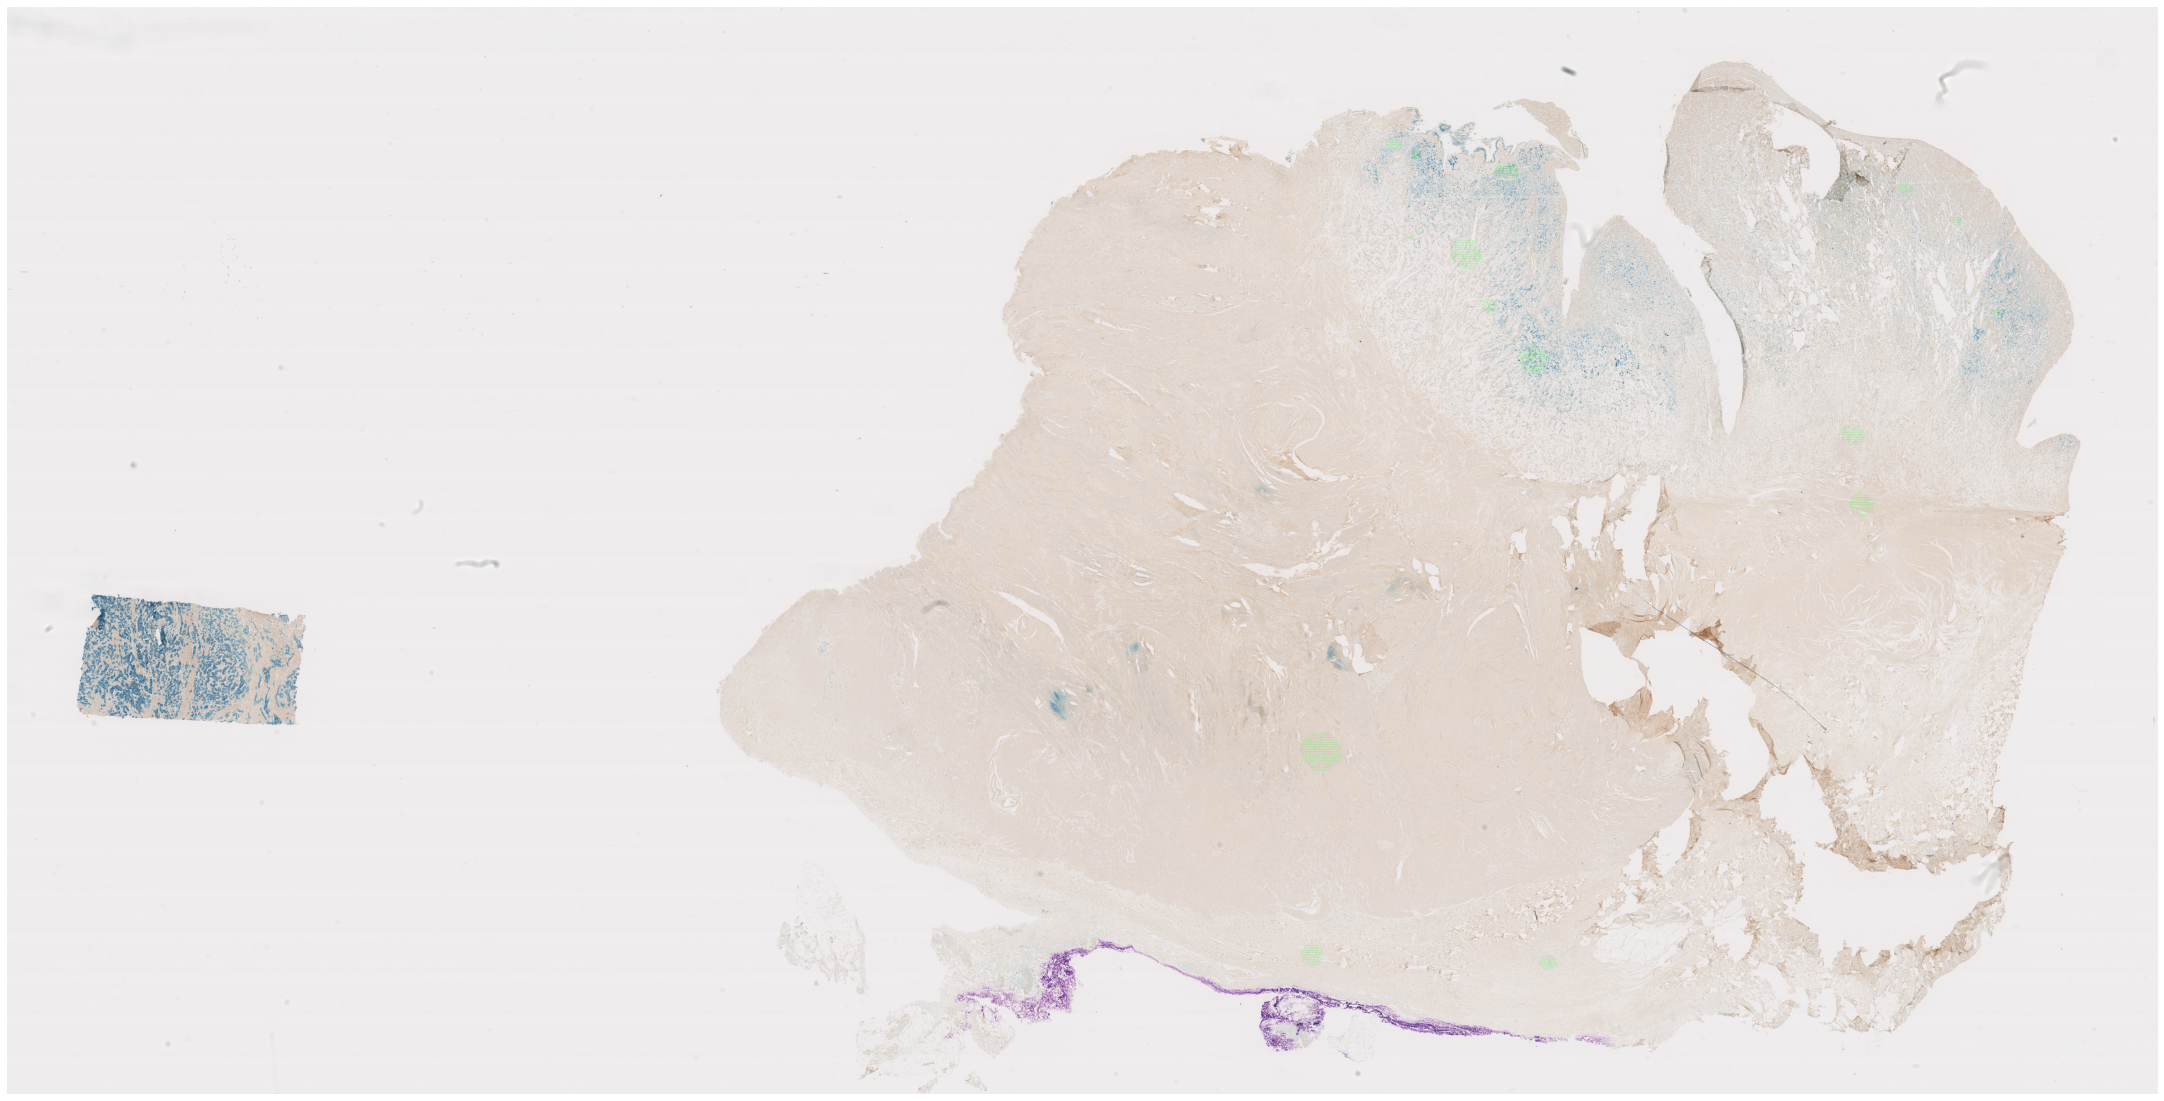

In [ ]:
path_xml = 'ejemplo.xml'#un archivo ndpa es un tipo de archivo xml
lado_parche = 200

anotaciones_ndpi = read_xml(path_xml)
anotaciones_pixeles = transformacion_ndpi2pixeles(anotaciones_ndpi)
contenedor_esquinas = get_esquinas_parches(lado_parche, anotaciones_pixeles)


anotaciones_pixeles = transformacion_ndpi2pixeles(anotaciones_ndpi)
contenedor_esquinas = get_esquinas_parches(lado_parche, anotaciones_pixeles)#generar las esquinas de los parches de la roi
#######de x2.5 hacia abajo es es una magnificacion muy baja como para tomar decisiones, por eso se hace con mag x5
path_img='/content/gdrive/MyDrive/memoria/ejemplo_x5_z0.tif'
img = cv2.imread(path_img)
img = draw_grid(img, path_img,contenedor_esquinas, lado_parche, magnificacion_img=5)



#tupla_color_rojo = (255,0,0)    
#cv2.putText(img, 'radio_roi=', centro_roi, font, fontScale, color = tupla_color_rojo , thickness, cv2.LINE_AA)
#cv2.putText(img,'centro_roi = '+str(centro_roi[0])+','+str(centro_roi[1]) , centro_roi, font, fontScale, color=(255,0,0), thickness=2, cv2.LINE_AA,False)



print('ancho es img.shape[0] = ',img.shape[0], '        largo es img.shape[1] = ',img.shape[1])

fig = plt.figure(figsize=(int(20*(img.shape[1]/img.shape[0])), 20))
plt.imshow(img)
plt.axis('off')

folder_path='/content/gdrive/MyDrive/memoria/'
cv2.imwrite(folder_path+'ejemplo_rois_dibujadas.tif',img)



